In [17]:
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pickle

def create_grid_domains():
    ds = xr.open_dataset('/Users/clamalo/downloads/test2.nc')
    start_lat, start_lon = 32, -125
    end_lat, end_lon = 50, -103
    start_lat_idx = ds.lat.values.searchsorted(start_lat)
    end_lat_idx = ds.lat.values.searchsorted(end_lat)
    start_lon_idx = ds.lon.values.searchsorted(start_lon)
    end_lon_idx = ds.lon.values.searchsorted(end_lon)
    grid_domains = {}
    total_domains = 0
    for lat_idx in range(start_lat_idx, end_lat_idx, 64):
        for lon_idx in range(start_lon_idx, end_lon_idx, 64):
            cropped_ds = ds.isel(lat=slice(lat_idx, lat_idx+64), lon=slice(lon_idx, lon_idx+64))
            grid_domains[total_domains] = [lat_idx, lat_idx+64, lon_idx, lon_idx+64]
            total_domains += 1
    with open('/Users/clamalo/downloads/grid_domains.pkl', 'wb') as f:
        pickle.dump(grid_domains, f)

create_grid_domains()

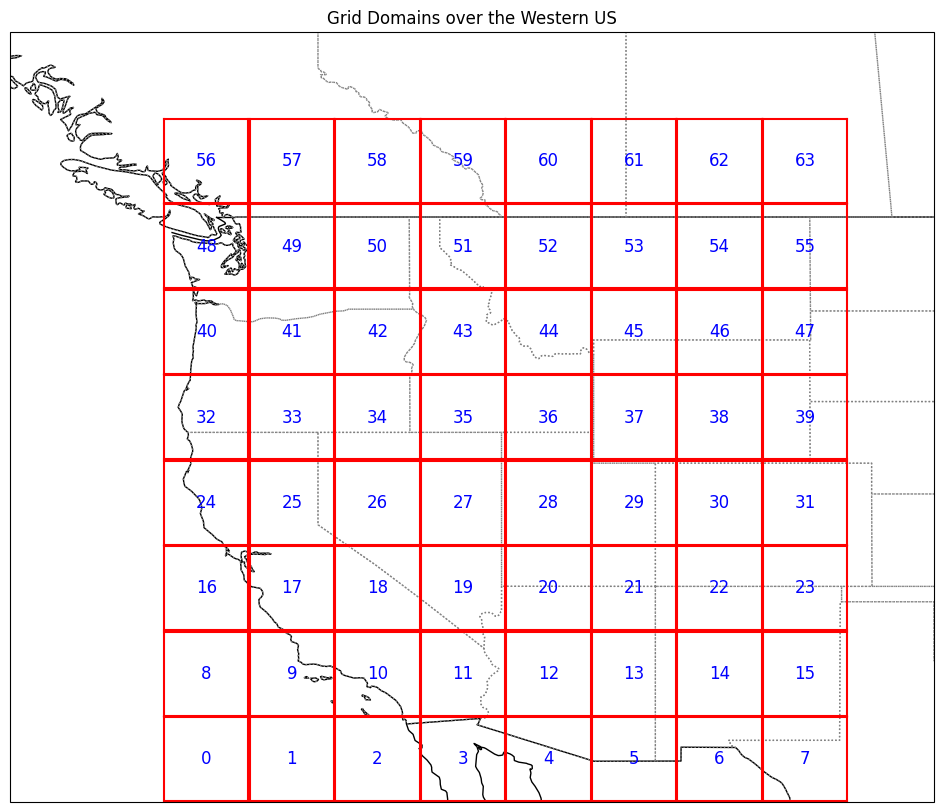

In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

def plot_grid_domains(grid_file, dataset_file):
    # Load the grid domains
    with open(grid_file, 'rb') as f:
        grid_domains = pickle.load(f)
    
    # Load the dataset for geographic context
    ds = xr.open_dataset(dataset_file)

    # Create a figure and axis with the correct projection
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-130, -100, 30, 55], ccrs.PlateCarree())  # Western US region

    # Add features to the map
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    # Plot each grid domain
    for domain_id, (lat_start, lat_end, lon_start, lon_end) in grid_domains.items():
        lat_values = ds.lat.values[lat_start:lat_end]
        lon_values = ds.lon.values[lon_start:lon_end]
        
        # Define the corner points of the grid box
        lon_min, lon_max = lon_values[0], lon_values[-1]
        lat_min, lat_max = lat_values[0], lat_values[-1]
        
        # Plot the rectangle for the grid domain
        ax.plot([lon_min, lon_max], [lat_min, lat_min], color='red')
        ax.plot([lon_min, lon_max], [lat_max, lat_max], color='red')
        ax.plot([lon_min, lon_min], [lat_min, lat_max], color='red')
        ax.plot([lon_max, lon_max], [lat_min, lat_max], color='red')
        
        # Place the domain ID in the center of the grid box
        ax.text((lon_min + lon_max) / 2, (lat_min + lat_max) / 2, str(domain_id), 
                color='blue', fontsize=12, ha='center', va='center')
    
    plt.title('Grid Domains over the Western US')
    plt.show()

# Usage
grid_file = '/Users/clamalo/downloads/grid_domains.pkl'
dataset_file = '/Users/clamalo/downloads/test2.nc'
plot_grid_domains(grid_file, dataset_file)